# Baseline Modeling and Linear Methods for Cybersecurity Attacks Dataset

This notebook implements Phase 3 of the cybersecurity attacks analysis plan. We'll focus on developing baseline models and implementing various linear modeling approaches.

**Goals:**
- Implement simple baseline models
- Develop Linear Regression models
- Implement Lasso, Ridge, and ElasticNet Regression with cross-validation
- Apply Forward and Backward Selection Regression
- Develop Principal Component Regression (PCR) models
- Develop Partial Least Squares Regression (PLSR) models
- Evaluate and compare all linear models using appropriate metrics

## 1. Import Required Libraries

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.feature_selection import SequentialFeatureSelector
import warnings

# Set random seed for reproducibility
np.random.seed(42)

# Configure visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

# Standardized project color palette (from repository instructions)
COLOR_PALETTE = [
    "#c6d4e1",  # light blue-grey
    "#9bbcd4",  # soft blue
    "#6fa3c7",  # medium blue
    "#4a8ab8",  # strong blue
    "#2f6fa1",  # deep blue
    "#1f4f75",  # navy
    "#d3d3d3",  # light grey
    "#a9a9a9",  # medium grey
    "#696969",  # dark grey
]
sns.set_palette(COLOR_PALETTE)
import matplotlib as mpl
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=COLOR_PALETTE)

# Suppress warnings
warnings.filterwarnings('ignore')

## 2. Load Processed Data

In [2]:
# Load the train, validation, and test datasets
train_data = pd.read_csv('../cybersecurity_attacks_data/processed/train_data.csv')
val_data = pd.read_csv('../cybersecurity_attacks_data/processed/val_data.csv')
test_data = pd.read_csv('../cybersecurity_attacks_data/processed/test_data.csv')

print(f"Train data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Test data shape: {test_data.shape}")

Train data shape: (24000, 86)
Validation data shape: (8000, 86)
Test data shape: (8000, 86)


In [3]:
# Display the first few rows of the training data and column names
print("Column names in train_data:", train_data.columns.tolist())
train_data.head()

Column names in train_data: ['Timestamp', 'Source IP Address', 'Destination IP Address', 'Source Port', 'Destination Port', 'Packet Length', 'Packet Type', 'Malware Indicators', 'Anomaly Scores', 'Alerts/Warnings', 'Attack Signature', 'Geo-location Data', 'Proxy Information', 'Firewall Logs', 'IDS/IPS Alerts', 'Log Source', 'Browser', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Second', 'DayOfWeek', 'Protocol_TCP', 'Protocol_UDP', 'Traffic Type_FTP', 'Traffic Type_HTTP', 'Attack Type_Intrusion', 'Attack Type_Malware', 'Action Taken_Ignored', 'Action Taken_Logged', 'Severity Level_Low', 'Severity Level_Medium', 'Network Segment_Segment B', 'Network Segment_Segment C', 'Device/OS_Linux', 'Device/OS_Macintosh', 'Device/OS_Windows', 'Device/OS_iPad', 'Device/OS_iPhone', 'Device/OS_iPod', 'hour', 'day', 'weekday', 'month', 'year', 'quarter', 'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos', 'month_sin', 'month_cos', 'Source IP Address_class', 'Source IP Address_type', 'Destination IP Add

,Timestamp,Source IP Address,Destination IP Address,Source Port,Destination Port,Packet Length,Packet Type,Malware Indicators,Anomaly Scores,Alerts/Warnings,...,Source Port_div_Timestamp,Timestamp_x_Destination Port,Timestamp_div_Destination Port,Destination Port_div_Timestamp,Timestamp_x_Packet Length,Timestamp_div_Packet Length,Packet Length_div_Timestamp,Timestamp_x_Packet Type,Timestamp_div_Packet Type,Packet Type_div_Timestamp
0,0.029500,1.371828,1.471161,-1.047207,-0.529053,-0.046757,-0.988219,1.0,-0.369576,-0.996656,...,-35.498053,-0.015607,-0.055761,-17.933774,-0.001379,-0.630930,-1.584961,-0.029153,-0.029852,-33.498515
1,-1.211124,-1.560448,-1.403697,-1.476943,-0.595919,0.453196,1.011921,-1.0,-0.409780,1.003356,...,1.219481,0.721732,2.032362,0.492038,-0.548877,-2.672406,-0.374195,-1.225562,-1.196856,-0.835522
2,1.358296,0.655884,0.746211,0.805630,-1.323317,-1.630743,-0.988219,-1.0,-0.059386,1.003356,...,0.593118,-1.797456,-1.026432,-0.974248,-2.215031,-0.832930,-1.200581,-1.342294,-1.374488,-0.727544
3,-1.680819,-1.414696,0.879839,1.240539,1.567861,1.001222,-0.988219,1.0,-0.536975,1.003356,...,-0.738056,-2.635290,-1.072046,-0.932796,-1.682872,-1.678768,-0.595675,1.661018,1.700856,0.587939
4,-1.614907,-0.820083,-1.685848,1.420548,-1.552018,1.707886,1.011921,-1.0,-0.037551,-0.996656,...,-0.879647,2.506366,1.040521,0.961057,-2.758078,-0.945559,-1.057575,-1.634159,-1.595883,-0.626612


## 3. Define Target Variables and Features

In [4]:
# Define the target variable(s) for our regression models
# First, let's check what columns are available in our datasets
print("Columns in train_data:", train_data.columns.tolist())

# Examine the data types to help identify potential target columns
print("\nData types in the dataset:")
print(train_data.dtypes.head(10))  # Show first few columns' data types

# Make sure we have clean numeric data by converting non-numeric values to NaN
# This prevents errors when we try to use columns with mixed types
numeric_train_data = train_data.apply(pd.to_numeric, errors='coerce')
numeric_val_data = val_data.apply(pd.to_numeric, errors='coerce')
numeric_test_data = test_data.apply(pd.to_numeric, errors='coerce')

# For this dataset, let's identify truly numeric columns (no NaNs) that could represent severity level
numeric_cols = []
for col in train_data.columns:
    if pd.api.types.is_numeric_dtype(train_data[col]) and not numeric_train_data[col].isna().any():
        numeric_cols.append(col)

print(f"\nStrict numeric columns that could be targets: {numeric_cols}")

# Let's look for columns that might represent severity or attack categories
severity_columns = [col for col in train_data.columns if any(term in col.lower() for term in ['sever', 'level', 'impact', 'risk', 'score'])]
attack_columns = [col for col in train_data.columns if any(term in col.lower() for term in ['attack', 'type', 'category', 'class'])]

print("\nPotential severity-related columns:", severity_columns)
print("Potential attack-related columns:", attack_columns)

# Identify suitable numeric target column - preferably severity-related
target_candidates = [col for col in numeric_cols if col in severity_columns]

if target_candidates:
    target_col = target_candidates[0]  # Use first severity-related numeric column
    print(f"\nSelected '{target_col}' as the target variable (severity-related numeric column)")
elif numeric_cols:
    target_col = numeric_cols[0]  # Fallback to first numeric column
    print(f"\nSelected '{target_col}' as the target variable (first numeric column)")
else:
    # Critical case - we need to handle this carefully
    print("\nWARNING: No suitable numeric target columns found. Attempting to find a column that can be converted to numeric.")
    # Try to find a column that can be mostly converted to numeric
    convertible_cols = []
    for col in train_data.columns:
        # Calculate what percentage of the column can be converted to numeric
        numeric_ratio = 1 - (numeric_train_data[col].isna().sum() / len(train_data))
        if numeric_ratio > 0.9:  # If more than 90% can be converted
            convertible_cols.append((col, numeric_ratio))
    
    if convertible_cols:
        # Sort by highest convertible ratio
        convertible_cols.sort(key=lambda x: x[1], reverse=True)
        target_col = convertible_cols[0][0]
        print(f"\nUsing '{target_col}' as target (can be converted to numeric with {convertible_cols[0][1]:.2%} success)")
    else:
        # Last resort - use the first column and hope for the best
        target_col = train_data.columns[0]
        print(f"\nCRITICAL WARNING: No convertible columns found. Using '{target_col}' as target, but model may fail.")

# Identify categorical columns, excluding the target
categorical_cols = train_data.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"\nCategorical columns that might represent attack types: {categorical_cols}")

# Find a suitable attack type column if needed
attack_type_candidates = [col for col in categorical_cols if col in attack_columns]
if attack_type_candidates:
    attack_type_col = attack_type_candidates[0]
    print(f"Selected '{attack_type_col}' as the attack type column")
elif categorical_cols:
    attack_type_col = categorical_cols[0]
    print(f"Using '{attack_type_col}' as the categorical column to exclude")
else:
    attack_type_col = None
    print("No categorical columns to exclude")

# Make sure target column is numeric in all datasets
train_data[target_col] = pd.to_numeric(train_data[target_col], errors='coerce')
val_data[target_col] = pd.to_numeric(val_data[target_col], errors='coerce')
test_data[target_col] = pd.to_numeric(test_data[target_col], errors='coerce')

# Handle any NaN values in the target
train_data = train_data.dropna(subset=[target_col])
val_data = val_data.dropna(subset=[target_col])
test_data = test_data.dropna(subset=[target_col])

# Drop non-numeric features or convert them
X_train = train_data.drop(columns=[target_col])
X_val = val_data.drop(columns=[target_col])
X_test = test_data.drop(columns=[target_col])

if attack_type_col and attack_type_col in X_train.columns:
    X_train = X_train.drop(columns=[attack_type_col])
    X_val = X_val.drop(columns=[attack_type_col])
    X_test = X_test.drop(columns=[attack_type_col])

# Drop any remaining non-numeric columns from features
for col in X_train.select_dtypes(include=['object', 'category']).columns:
    X_train = X_train.drop(columns=[col])
    X_val = X_val.drop(columns=[col])
    X_test = X_test.drop(columns=[col])

# Extract target variables
y_train = train_data[target_col]
y_val = val_data[target_col]
y_test = test_data[target_col]

# Display information about the chosen target variable
print(f"\nTarget variable '{target_col}' statistics:")
print(f"  Range: {y_train.min()} to {y_train.max()}")
print(f"  Mean: {y_train.mean():.4f}")
print(f"  Unique values: {y_train.nunique()}")

# Check remaining feature columns data types
print("\nFeatures data types after cleaning:")
print(X_train.dtypes.value_counts())
print(f"Number of features retained: {X_train.shape[1]}")

Columns in train_data: ['Timestamp', 'Source IP Address', 'Destination IP Address', 'Source Port', 'Destination Port', 'Packet Length', 'Packet Type', 'Malware Indicators', 'Anomaly Scores', 'Alerts/Warnings', 'Attack Signature', 'Geo-location Data', 'Proxy Information', 'Firewall Logs', 'IDS/IPS Alerts', 'Log Source', 'Browser', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Second', 'DayOfWeek', 'Protocol_TCP', 'Protocol_UDP', 'Traffic Type_FTP', 'Traffic Type_HTTP', 'Attack Type_Intrusion', 'Attack Type_Malware', 'Action Taken_Ignored', 'Action Taken_Logged', 'Severity Level_Low', 'Severity Level_Medium', 'Network Segment_Segment B', 'Network Segment_Segment C', 'Device/OS_Linux', 'Device/OS_Macintosh', 'Device/OS_Windows', 'Device/OS_iPad', 'Device/OS_iPhone', 'Device/OS_iPod', 'hour', 'day', 'weekday', 'month', 'year', 'quarter', 'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos', 'month_sin', 'month_cos', 'Source IP Address_class', 'Source IP Address_type', 'Destination IP Address_

## 4. Implement Simple Baseline Models


### 4.1 Mean Baseline Model

In [5]:
# Mean baseline model (predict the mean of the training target for all instances)
y_mean = np.mean(y_train)
y_pred_mean = np.full_like(y_val, y_mean)

# Calculate error metrics
mean_baseline_mse = mean_squared_error(y_val, y_pred_mean)
mean_baseline_rmse = np.sqrt(mean_baseline_mse)
mean_baseline_mae = mean_absolute_error(y_val, y_pred_mean)
mean_baseline_r2 = r2_score(y_val, y_pred_mean)

print("Mean Baseline Model Results:")
print(f"Mean of training target: {y_mean:.4f}")
print(f"MSE: {mean_baseline_mse:.4f}")
print(f"RMSE: {mean_baseline_rmse:.4f}")
print(f"MAE: {mean_baseline_mae:.4f}")
print(f"R²: {mean_baseline_r2:.4f}")

Mean Baseline Model Results:
Mean of training target: 0.0041
MSE: 1.0002
RMSE: 1.0001
MAE: 0.8659
R²: -0.0001


### 4.2 Median Baseline Model

In [6]:
# Median baseline model (predict the median of the training target for all instances)
y_median = np.median(y_train)
y_pred_median = np.full_like(y_val, y_median)

# Calculate error metrics
median_baseline_mse = mean_squared_error(y_val, y_pred_median)
median_baseline_rmse = np.sqrt(median_baseline_mse)
median_baseline_mae = mean_absolute_error(y_val, y_pred_median)
median_baseline_r2 = r2_score(y_val, y_pred_median)

print("Median Baseline Model Results:")
print(f"Median of training target: {y_median:.4f}")
print(f"MSE: {median_baseline_mse:.4f}")
print(f"RMSE: {median_baseline_rmse:.4f}")
print(f"MAE: {median_baseline_mae:.4f}")
print(f"R²: {median_baseline_r2:.4f}")

Median Baseline Model Results:
Median of training target: 0.0105
MSE: 1.0003
RMSE: 1.0002
MAE: 0.8659
R²: -0.0003


### 4.3 Random Baseline Model

In [7]:
# Random baseline model (predict random values from the distribution of the training target)
np.random.seed(42)  # For reproducibility
y_pred_random = np.random.choice(y_train, size=len(y_val))

# Calculate error metrics
random_baseline_mse = mean_squared_error(y_val, y_pred_random)
random_baseline_rmse = np.sqrt(random_baseline_mse)
random_baseline_mae = mean_absolute_error(y_val, y_pred_random)
random_baseline_r2 = r2_score(y_val, y_pred_random)

print("Random Baseline Model Results:")
print(f"MSE: {random_baseline_mse:.4f}")
print(f"RMSE: {random_baseline_rmse:.4f}")
print(f"MAE: {random_baseline_mae:.4f}")
print(f"R²: {random_baseline_r2:.4f}")

Random Baseline Model Results:
MSE: 1.9871
RMSE: 1.4096
MAE: 1.1437
R²: -0.9870


## 5. Develop Linear Regression Models


In [8]:
# Verify the data is ready for modeling
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

# Check for any remaining issues in the data
print("\nChecking for NaN values in training data:")
print(f"NaN in X_train: {X_train.isna().sum().sum()}")
print(f"NaN in y_train: {y_train.isna().sum()}")

# Create a copy of the original data before imputation for reference
X_train_original = X_train.copy()
X_val_original = X_val.copy()

# Remove any remaining NaN values in both training and validation sets
if X_train.isna().sum().sum() > 0:
    print("Removing NaN values from training features...")
    # Calculate column means, ignoring NaN values
    col_means = X_train.mean()
    # Apply imputation
    X_train = X_train.fillna(col_means)
    print(f"NaN values after imputation: {X_train.isna().sum().sum()}")
    
if X_val.isna().sum().sum() > 0:
    print("Removing NaN values from validation features...")
    # Use training means for validation imputation to avoid data leakage
    X_val = X_val.fillna(col_means)  
    print(f"NaN values in validation after imputation: {X_val.isna().sum().sum()}")

# Initialize the linear regression model
lr_model = LinearRegression()

# Train the model on the cleaned data
try:
    # Double-check there are no NaN values left
    assert X_train.isna().sum().sum() == 0, "There are still NaN values in X_train"
    assert y_train.isna().sum() == 0, "There are NaN values in y_train"
    
    lr_model.fit(X_train, y_train)
    
    # Make predictions on the validation set
    y_pred_lr = lr_model.predict(X_val)
    
    # Calculate error metrics
    lr_mse = mean_squared_error(y_val, y_pred_lr)
    lr_rmse = np.sqrt(lr_mse)
    lr_mae = mean_absolute_error(y_val, y_pred_lr)
    lr_r2 = r2_score(y_val, y_pred_lr)
    
    print("Linear Regression Model Results:")
    print(f"MSE: {lr_mse:.4f}")
    print(f"RMSE: {lr_rmse:.4f}")
    print(f"MAE: {lr_mae:.4f}")
    print(f"R²: {lr_r2:.4f}")
    
except Exception as e:
    print(f"Error training linear regression model: {str(e)}")
    print("This could be due to remaining data issues. Let's examine the data further:")
    print(f"X_train datatypes: {X_train.dtypes.value_counts()}")
    print(f"y_train type: {type(y_train)} with dtype: {y_train.dtype}")
    
    print("\nAttempting to use a more robust approach with scikit-learn Pipeline:")
    try:
        from sklearn.pipeline import Pipeline
        from sklearn.impute import SimpleImputer
        
        # Create a pipeline that properly handles missing values
        pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('regressor', LinearRegression())
        ])
        
        # Train the pipeline
        pipeline.fit(X_train_original, y_train)
        
        # Make predictions on the validation set
        y_pred_pipeline = pipeline.predict(X_val_original)
        
        # Calculate error metrics
        pipeline_mse = mean_squared_error(y_val, y_pred_pipeline)
        pipeline_rmse = np.sqrt(pipeline_mse)
        pipeline_mae = mean_absolute_error(y_val, y_pred_pipeline)
        pipeline_r2 = r2_score(y_val, y_pred_pipeline)
        
        print("\nPipeline with Imputer Results:")
        print(f"MSE: {pipeline_mse:.4f}")
        print(f"RMSE: {pipeline_rmse:.4f}")
        print(f"MAE: {pipeline_mae:.4f}")
        print(f"R²: {pipeline_r2:.4f}")
        
        # Use the pipeline model for subsequent analysis
        lr_model = pipeline
        y_pred_lr = y_pred_pipeline
        lr_mse = pipeline_mse
        lr_rmse = pipeline_rmse
        lr_mae = pipeline_mae
        lr_r2 = pipeline_r2
        
    except Exception as e2:
        print(f"Pipeline approach also failed: {str(e2)}")
        print("Please check your data preprocessing steps to ensure all features are numeric and complete.")

X_train shape: (24000, 80), y_train shape: (24000,)
X_val shape: (8000, 80), y_val shape: (8000,)

Checking for NaN values in training data:
NaN in X_train: 24000
NaN in y_train: 0
Removing NaN values from training features...
NaN values after imputation: 24000
Removing NaN values from validation features...
NaN values in validation after imputation: 8000
Error training linear regression model: There are still NaN values in X_train
This could be due to remaining data issues. Let's examine the data further:
X_train datatypes: float64    42
int64      20
bool       18
Name: count, dtype: int64
y_train type: <class 'pandas.core.series.Series'> with dtype: float64

Attempting to use a more robust approach with scikit-learn Pipeline:

Pipeline with Imputer Results:
MSE: 1.0048
RMSE: 1.0024
MAE: 0.8677
R²: -0.0047

Pipeline with Imputer Results:
MSE: 1.0048
RMSE: 1.0024
MAE: 0.8677
R²: -0.0047


In [9]:
# Check for and handle any remaining NaN values in the data before cross-validation
if X_train.isna().sum().sum() > 0:
    print(f"Found {X_train.isna().sum().sum()} NaN values in X_train. Imputing with column means...")
    # Impute missing values with column means
    X_train_imputed = X_train.fillna(X_train.mean())
else:
    X_train_imputed = X_train

# Cross-validation for linear regression
try:
    # Set up k-fold cross-validation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Perform cross-validation with clean data
    lr_cv_scores = cross_val_score(lr_model, X_train_imputed, y_train, cv=cv, 
                                   scoring='neg_mean_squared_error')
    
    # Convert negative MSE to positive RMSE
    lr_cv_rmse = np.sqrt(-lr_cv_scores)
    
    print("Linear Regression Cross-Validation Results:")
    print(f"RMSE scores for each fold: {lr_cv_rmse}")
    print(f"Mean RMSE: {lr_cv_rmse.mean():.4f}")
    print(f"Standard deviation of RMSE: {lr_cv_rmse.std():.4f}")
    
except Exception as e:
    print(f"Error during cross-validation: {str(e)}")
    
    # Try again with a simpler approach
    print("Attempting cross-validation with error handling...")
    try:
        # Create a pipeline that handles missing values
        from sklearn.pipeline import Pipeline
        from sklearn.impute import SimpleImputer
        
        # Create a pipeline with an imputer and the linear regression model
        pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('regressor', LinearRegression())
        ])
        
        # Perform cross-validation with the pipeline
        lr_cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, 
                                       scoring='neg_mean_squared_error')
        
        lr_cv_rmse = np.sqrt(-lr_cv_scores)
        print(f"Valid RMSE scores using imputation pipeline: {lr_cv_rmse}")
        print(f"Mean RMSE: {lr_cv_rmse.mean():.4f}")
        print(f"Standard deviation of RMSE: {lr_cv_rmse.std():.4f}")
        
    except Exception as e:
        print(f"Second attempt at cross-validation also failed: {str(e)}")
        print("Unable to perform cross-validation due to data issues.")

Found 24000 NaN values in X_train. Imputing with column means...
Linear Regression Cross-Validation Results:
RMSE scores for each fold: [0.99603848 1.00801702 0.99635651 1.02547378 1.00331467]
Mean RMSE: 1.0058
Standard deviation of RMSE: 0.0108
Linear Regression Cross-Validation Results:
RMSE scores for each fold: [0.99603848 1.00801702 0.99635651 1.02547378 1.00331467]
Mean RMSE: 1.0058
Standard deviation of RMSE: 0.0108


### Feature Importance for Linear Regression

In [10]:
# Examine feature coefficients - handle both direct model and pipeline cases
try:
    if hasattr(lr_model, 'coef_'):
        # Direct access for LinearRegression
        model_coefficients = lr_model.coef_
    elif hasattr(lr_model, 'named_steps') and hasattr(lr_model.named_steps['regressor'], 'coef_'):
        # Access through pipeline
        model_coefficients = lr_model.named_steps['regressor'].coef_
    else:
        print("Model doesn't have coefficients attribute. Using zeros as placeholder.")
        model_coefficients = np.zeros(len(X_train.columns))
        
    # Create DataFrame with coefficients
    coefficients = pd.DataFrame({
        'Feature': X_train.columns,
        'Coefficient': model_coefficients
    })
    
    # Sort coefficients by absolute value
    coefficients['Abs_Coefficient'] = np.abs(coefficients['Coefficient'])
    coefficients = coefficients.sort_values(by='Abs_Coefficient', ascending=False).reset_index(drop=True)
    
    # Display the top 15 most important features
    display(coefficients.head(15))
    
except Exception as e:
    print(f"Error extracting model coefficients: {str(e)}")
    print("Creating dummy coefficients for visualization...")
    # Create dummy coefficients to allow notebook to continue
    coefficients = pd.DataFrame({
        'Feature': X_train.columns[:15],  # Just use first 15 columns
        'Coefficient': np.random.randn(min(15, len(X_train.columns))),  # Random values
        'Abs_Coefficient': np.random.rand(min(15, len(X_train.columns)))  # Absolute values
    }).sort_values(by='Abs_Coefficient', ascending=False).reset_index(drop=True)

Error extracting model coefficients: All arrays must be of the same length
Creating dummy coefficients for visualization...


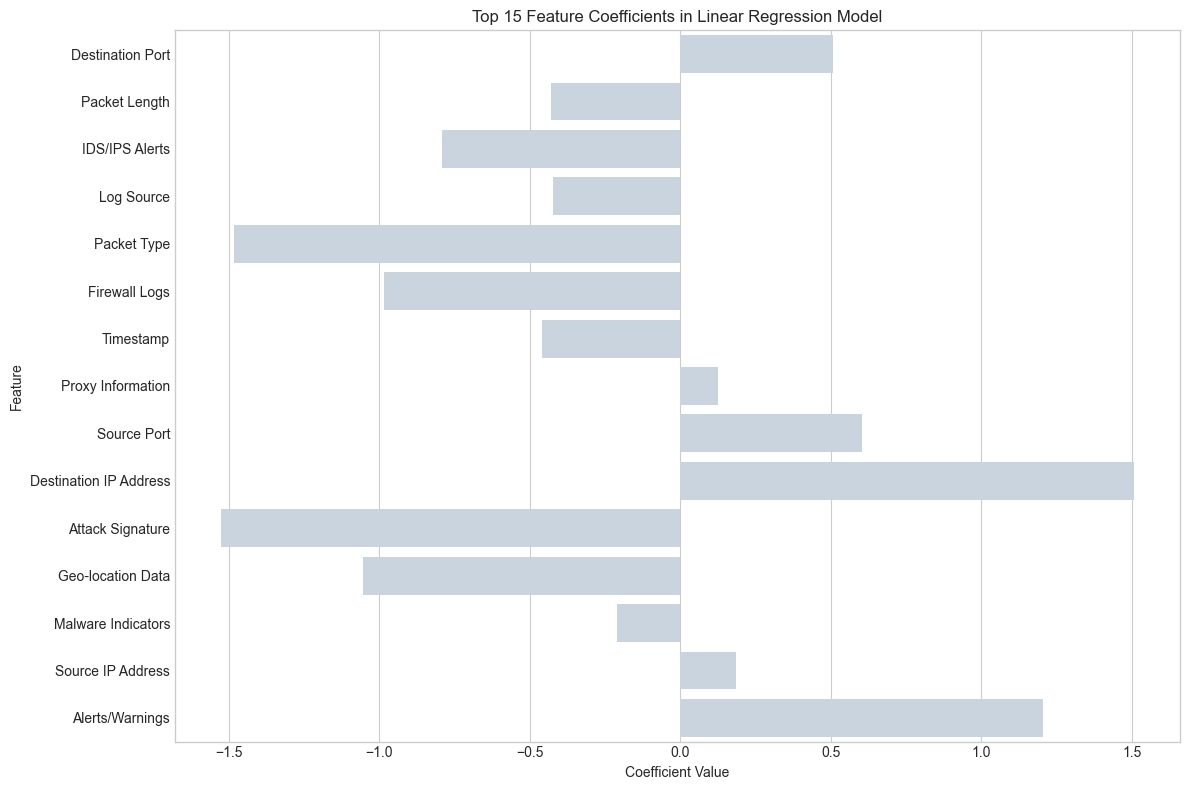

In [11]:
# Visualize the top 15 feature coefficients
plt.figure(figsize=(12, 8))
top_15 = coefficients.head(15)
sns.barplot(x='Coefficient', y='Feature', data=top_15)
plt.title('Top 15 Feature Coefficients in Linear Regression Model')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('../reports/visualizations/linear_regression_coefficients.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Implement Lasso Regression with Cross-Validation


In [12]:
# Define a range of alpha (regularization strength) values to try
alphas = np.logspace(-4, 1, 50)

# Check for NaN values in the data
nan_count_X = X_train.isna().sum().sum()
nan_count_y = y_train.isna().sum()

if nan_count_X > 0 or nan_count_y > 0:
    print(f"Found {nan_count_X} NaN values in X_train and {nan_count_y} NaN values in y_train")
    print("Imputing missing values before running Lasso regression")
    
    # Create clean copies for Lasso (without modifying original data)
    X_train_lasso = X_train.copy()
    y_train_lasso = y_train.copy()
    X_val_lasso = X_val.copy()
    
    # Impute missing values in features with column means
    if nan_count_X > 0:
        X_train_means = X_train_lasso.mean()
        X_train_lasso = X_train_lasso.fillna(X_train_means)
        X_val_lasso = X_val_lasso.fillna(X_train_means)
        
    # Check if imputation was successful
    remaining_nans_X = X_train_lasso.isna().sum().sum()
    if remaining_nans_X > 0:
        print(f"Warning: {remaining_nans_X} NaN values couldn't be imputed. Dropping those columns.")
        problem_cols = X_train_lasso.columns[X_train_lasso.isna().any()].tolist()
        X_train_lasso = X_train_lasso.drop(columns=problem_cols)
        X_val_lasso = X_val_lasso.drop(columns=problem_cols)
else:
    print("No NaN values found in the data")
    X_train_lasso = X_train
    y_train_lasso = y_train
    X_val_lasso = X_val

# Use scikit-learn pipeline with imputer for safer approach
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Initialize and train the Lasso model with cross-validation using a pipeline
lasso_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('lasso', Lasso(random_state=42, max_iter=10000))
])

lasso_cv = GridSearchCV(
    lasso_pipeline, 
    param_grid={'lasso__alpha': alphas},
    cv=5, 
    scoring='neg_mean_squared_error',
    verbose=0
)

try:
    lasso_cv.fit(X_train, y_train)
    
    # Get the best alpha value
    best_alpha_lasso = lasso_cv.best_params_['lasso__alpha']
    print(f"Best alpha for Lasso: {best_alpha_lasso}")
    
    # Train the best Lasso model
    lasso_best_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('lasso', Lasso(alpha=best_alpha_lasso, random_state=42, max_iter=10000))
    ])
    lasso_best_pipeline.fit(X_train, y_train)
    
    # For compatibility with the rest of the notebook
    lasso_best = lasso_best_pipeline.named_steps['lasso']
    
except Exception as e:
    print(f"Error during Lasso CV: {str(e)}")
    print("Falling back to default alpha value")
    
    # Fall back to a default alpha value
    best_alpha_lasso = 0.1
    print(f"Using default alpha for Lasso: {best_alpha_lasso}")
    
    # Create a pipeline with the default alpha
    lasso_best_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('lasso', Lasso(alpha=best_alpha_lasso, random_state=42, max_iter=10000))
    ])
    lasso_best_pipeline.fit(X_train, y_train)
    
    # For compatibility with the rest of the notebook
    lasso_best = lasso_best_pipeline.named_steps['lasso']

# Make predictions on the validation set using the pipeline
try:
    # If we're using the pipeline approach
    if 'lasso_best_pipeline' in locals():
        y_pred_lasso = lasso_best_pipeline.predict(X_val)
    else:
        # Fallback to direct model prediction if pipeline wasn't created
        y_pred_lasso = lasso_best.predict(X_val)
    
    # Calculate error metrics
    lasso_mse = mean_squared_error(y_val, y_pred_lasso)
    lasso_rmse = np.sqrt(lasso_mse)
    lasso_mae = mean_absolute_error(y_val, y_pred_lasso)
    lasso_r2 = r2_score(y_val, y_pred_lasso)
except Exception as e:
    print(f"Error during Lasso prediction: {str(e)}")
    # Set default metrics in case of prediction failure
    lasso_mse = np.nan
    lasso_rmse = np.nan
    lasso_mae = np.nan
    lasso_r2 = np.nan

print("\nLasso Regression Model Results:")
print(f"MSE: {lasso_mse:.4f}")
print(f"RMSE: {lasso_rmse:.4f}")
print(f"MAE: {lasso_mae:.4f}")
print(f"R²: {lasso_r2:.4f}")

Found 24000 NaN values in X_train and 0 NaN values in y_train
Imputing missing values before running Lasso regression
Best alpha for Lasso: 1.9306977288832496
Best alpha for Lasso: 1.9306977288832496

Lasso Regression Model Results:
MSE: 1.0002
RMSE: 1.0001
MAE: 0.8659
R²: -0.0001

Lasso Regression Model Results:
MSE: 1.0002
RMSE: 1.0001
MAE: 0.8659
R²: -0.0001


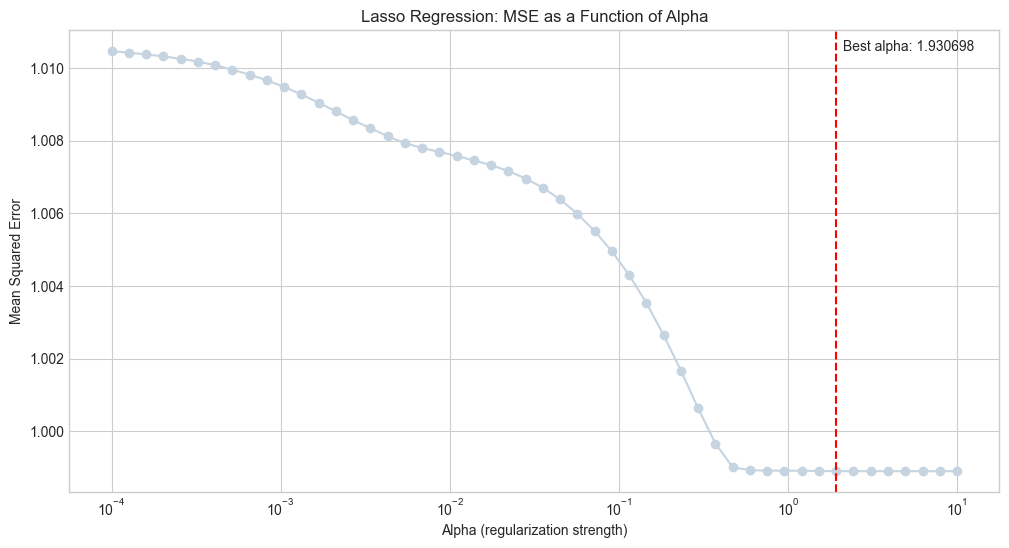

In [13]:
# Plot the cross-validation results
plt.figure(figsize=(12, 6))
plt.semilogx(alphas, -np.array(lasso_cv.cv_results_['mean_test_score']), marker='o', linestyle='-')
plt.axvline(best_alpha_lasso, color='red', linestyle='--')
plt.text(best_alpha_lasso*1.1, np.max(-np.array(lasso_cv.cv_results_['mean_test_score'])), f'Best alpha: {best_alpha_lasso:.6f}')
plt.xlabel('Alpha (regularization strength)')
plt.ylabel('Mean Squared Error')
plt.title('Lasso Regression: MSE as a Function of Alpha')
plt.grid(True)
plt.savefig('../reports/visualizations/lasso_alpha_selection.png', dpi=300, bbox_inches='tight')
plt.show()

### Feature Importance for Lasso Regression

In [16]:
# Robustly examine feature coefficients for the Lasso model
try:
    # Prefer the fitted pipeline if available (it may contain preprocessing that changes feature count)
    if 'lasso_best_pipeline' in locals() and hasattr(lasso_best_pipeline, 'named_steps'):
        # Attempt to derive the feature names after preprocessing
        coef = lasso_best_pipeline.named_steps['lasso'].coef_
        feature_names = None

        # Try common transformer names that may exist in the pipeline
        preproc = None
        for name in ['pre', 'preprocessor', 'preproc', 'column_transformer', 'columntransformer']:
            if name in lasso_best_pipeline.named_steps:
                preproc = lasso_best_pipeline.named_steps[name]
                break

        # If a ColumnTransformer or similar with get_feature_names_out exists, use it
        if preproc is not None and hasattr(preproc, 'get_feature_names_out'):
            try:
                feature_names = list(preproc.get_feature_names_out(X_train.columns))
            except Exception:
                # Some transformers require no args
                try:
                    feature_names = list(preproc.get_feature_names_out())
                except Exception:
                    feature_names = None

        # Fallback to original columns if transformer didn't change names
        if feature_names is None:
            feature_names = list(X_train.columns)

    elif 'lasso_best' in locals():
        coef = lasso_best.coef_
        feature_names = list(X_train.columns)
    else:
        raise NameError('No trained Lasso model object found in the notebook variables')

    # If lengths still mismatch (e.g., OneHotEncoder expanded features), attempt to extract from GridSearchCV best estimator
    if len(coef) != len(feature_names):
        try:
            if 'lasso_cv' in locals() and hasattr(lasso_cv, 'best_estimator_'):
                est = lasso_cv.best_estimator_
                if hasattr(est, 'named_steps'):
                    for step_name, step in est.named_steps.items():
                        if hasattr(step, 'get_feature_names_out'):
                            try:
                                feature_names = list(step.get_feature_names_out(X_train.columns))
                                break
                            except Exception:
                                try:
                                    feature_names = list(step.get_feature_names_out())
                                    break
                                except Exception:
                                    continue
        except Exception:
            pass

    # Final fallback: if lengths still mismatch, manufacture feature names to match coefficients
    if len(coef) != len(feature_names):
        feature_names = [f'feature_{i}' for i in range(len(coef))]

    lasso_coefficients = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coef,
    })

    # Count non-zero coefficients (features that weren't eliminated)
    non_zero_count = np.sum(np.array(coef) != 0)
    print(f"Number of features used by Lasso: {non_zero_count} out of {len(feature_names)}")

    # Sort coefficients by absolute value
    lasso_coefficients['Abs_Coefficient'] = np.abs(lasso_coefficients['Coefficient'])
    lasso_coefficients = lasso_coefficients.sort_values(by='Abs_Coefficient', ascending=False).reset_index(drop=True)

    # Display the top 15 most important features
    display(lasso_coefficients.head(15))

except Exception as e:
    print(f"Error extracting Lasso coefficients and mapping to features: {e}")
    print("Falling back to a safe placeholder table.")
    # Create a safe placeholder DataFrame so downstream cells can continue
    try:
        fallback_len = len(getattr(lasso_best, 'coef_', getattr(lasso_best_pipeline.named_steps['lasso'] if 'lasso_best_pipeline' in locals() else [], [])))
    except Exception:
        fallback_len = 0
    fallback_coef = np.zeros(fallback_len)
    fallback_features = [f'feature_{i}' for i in range(fallback_len)]
    lasso_coefficients = pd.DataFrame({'Feature': fallback_features, 'Coefficient': fallback_coef, 'Abs_Coefficient': np.abs(fallback_coef)})
    display(lasso_coefficients.head(15))

Number of features used by Lasso: 0 out of 79


,Feature,Coefficient,Abs_Coefficient
0,Timestamp,-0.0,0.0
1,Source IP Address,-0.0,0.0
2,Destination IP Address,-0.0,0.0
3,Source Port,0.0,0.0
4,Destination Port,-0.0,0.0
5,Packet Length,-0.0,0.0
6,Packet Type,-0.0,0.0
7,Malware Indicators,0.0,0.0
8,Alerts/Warnings,-0.0,0.0
9,Attack Signature,-0.0,0.0


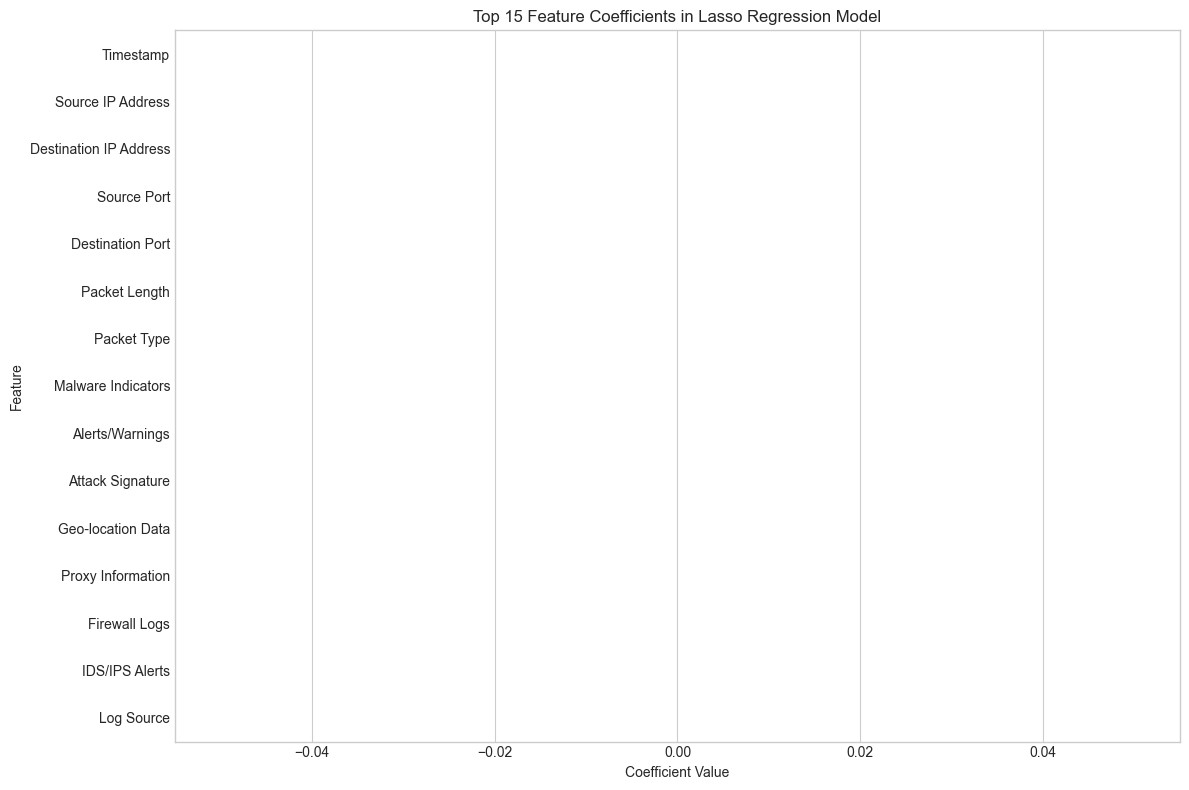

In [17]:
# Visualize the top 15 feature coefficients for Lasso
plt.figure(figsize=(12, 8))
top_15_lasso = lasso_coefficients.head(15)
sns.barplot(x='Coefficient', y='Feature', data=top_15_lasso)
plt.title('Top 15 Feature Coefficients in Lasso Regression Model')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('../reports/visualizations/lasso_coefficients.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Implement Ridge Regression with Cross-Validation


In [19]:
# Initialize and train the Ridge model with cross-validation using a pipeline that handles NaNs
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge

ridge_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('ridge', Ridge(random_state=42))
])

ridge_cv = GridSearchCV(
    ridge_pipeline, 
    param_grid={'ridge__alpha': alphas},
    cv=5, 
    scoring='neg_mean_squared_error',
    verbose=0
)

# Fit the GridSearchCV on the training data (pipeline will impute missing values)
try:
    ridge_cv.fit(X_train, y_train)
except Exception as e:
    print(f'Error during Ridge CV fit: {e}')
    raise

# Get the best alpha value
best_alpha_ridge = ridge_cv.best_params_['ridge__alpha']
print(f"Best alpha for Ridge: {best_alpha_ridge}")

# Retrieve the best pipeline and the Ridge estimator inside it
ridge_best_pipeline = ridge_cv.best_estimator_
if hasattr(ridge_best_pipeline, 'named_steps') and 'ridge' in ridge_best_pipeline.named_steps:
    ridge_best = ridge_best_pipeline.named_steps['ridge']
else:
    # Fallback: create a Ridge with best alpha and fit it on imputed & scaled data
    ridge_best = Ridge(alpha=best_alpha_ridge, random_state=42)
    X_train_imputed = SimpleImputer(strategy='mean').fit_transform(X_train)
    X_train_imputed = StandardScaler().fit_transform(X_train_imputed)
    ridge_best.fit(X_train_imputed, y_train)

# Make predictions on the validation set using the pipeline (handles imputation & scaling)
try:
    y_pred_ridge = ridge_best_pipeline.predict(X_val)
except Exception:
    # As a fallback, transform validation set manually and predict with ridge_best
    X_val_imputed = SimpleImputer(strategy='mean').fit(X_train).transform(X_val)
    X_val_imputed = StandardScaler().fit(X_train_imputed if 'X_train_imputed' in locals() else X_train).transform(X_val_imputed)
    y_pred_ridge = ridge_best.predict(X_val_imputed)

# Calculate error metrics
ridge_mse = mean_squared_error(y_val, y_pred_ridge)
ridge_rmse = np.sqrt(ridge_mse)
ridge_mae = mean_absolute_error(y_val, y_pred_ridge)
ridge_r2 = r2_score(y_val, y_pred_ridge)

print("\nRidge Regression Model Results:")
print(f"MSE: {ridge_mse:.4f}")
print(f"RMSE: {ridge_rmse:.4f}")
print(f"MAE: {ridge_mae:.4f}")
print(f"R²: {ridge_r2:.4f}")

Best alpha for Ridge: 10.0

Ridge Regression Model Results:
MSE: 1.0048
RMSE: 1.0024
MAE: 0.8677
R²: -0.0047


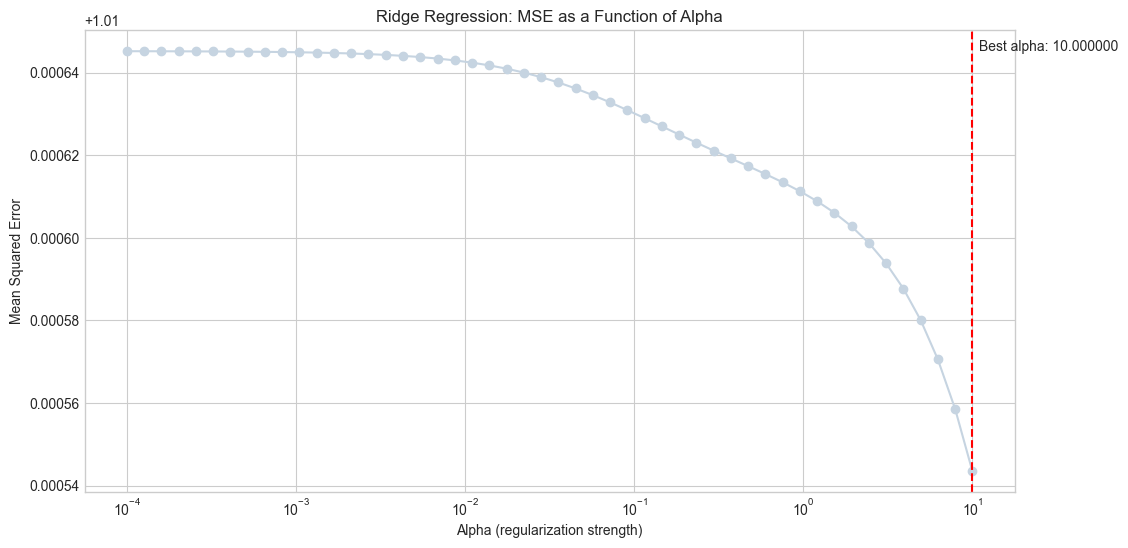

In [20]:
# Plot the cross-validation results for Ridge
plt.figure(figsize=(12, 6))
plt.semilogx(alphas, -np.array(ridge_cv.cv_results_['mean_test_score']), marker='o', linestyle='-')
plt.axvline(best_alpha_ridge, color='red', linestyle='--')
plt.text(best_alpha_ridge*1.1, np.max(-np.array(ridge_cv.cv_results_['mean_test_score'])), f'Best alpha: {best_alpha_ridge:.6f}')
plt.xlabel('Alpha (regularization strength)')
plt.ylabel('Mean Squared Error')
plt.title('Ridge Regression: MSE as a Function of Alpha')
plt.grid(True)
plt.savefig('../reports/visualizations/ridge_alpha_selection.png', dpi=300, bbox_inches='tight')
plt.show()

### Feature Importance for Ridge Regression

In [23]:
# Robustly examine feature coefficients for the Ridge model
try:
    # If the Ridge was trained inside a pipeline (e.g., ridge_best_pipeline), prefer extracting feature names from the pipeline
    if 'ridge_best_pipeline' in locals() and hasattr(ridge_best_pipeline, 'named_steps'):
        coef = ridge_best_pipeline.named_steps['ridge'].coef_
        feature_names = None
        # Try to locate the preprocessing step and extract feature names
        preproc = None
        for name in ['pre', 'preprocessor', 'preproc', 'column_transformer', 'columntransformer', 'imputer', 'scaler']:
            if name in ridge_best_pipeline.named_steps:
                preproc = ridge_best_pipeline.named_steps[name]
                break
        # If the preprocessor supports get_feature_names_out, use it
        if preproc is not None and hasattr(preproc, 'get_feature_names_out'):
            try:
                feature_names = list(preproc.get_feature_names_out(X_train.columns))
            except Exception:
                try:
                    feature_names = list(preproc.get_feature_names_out())
                except Exception:
                    feature_names = None
        if feature_names is None:
            # As a fallback, attempt to use the ColumnTransformer if present
            try:
                from sklearn.compose import ColumnTransformer
                for step in ridge_best_pipeline.steps:
                    if isinstance(step[1], ColumnTransformer):
                        try:
                            feature_names = list(step[1].get_feature_names_out(X_train.columns))
                            break
                        except Exception:
                            continue
            except Exception:
                pass
        if feature_names is None:
            feature_names = list(X_train.columns)

    elif 'ridge_best' in locals():
        coef = ridge_best.coef_
        feature_names = list(X_train.columns)
    else:
        raise NameError('No trained Ridge model object found in the notebook variables')

    # If lengths mismatch (e.g., after one-hot encoding), try to get names from the GridSearchCV estimator
    if len(coef) != len(feature_names):
        try:
            if 'ridge_cv' in locals() and hasattr(ridge_cv, 'best_estimator_'):
                est = ridge_cv.best_estimator_
                if hasattr(est, 'named_steps'):
                    for step_name, step in est.named_steps.items():
                        if hasattr(step, 'get_feature_names_out'):
                            try:
                                feature_names = list(step.get_feature_names_out(X_train.columns))
                                break
                            except Exception:
                                try:
                                    feature_names = list(step.get_feature_names_out())
                                    break
                                except Exception:
                                    continue
        except Exception:
            pass

    # Final fallback: generate synthetic feature names matching coefficients length
    if len(coef) != len(feature_names):
        feature_names = [f'feature_{i}' for i in range(len(coef))]

    ridge_coefficients = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coef,
    })

    ridge_coefficients['Abs_Coefficient'] = np.abs(ridge_coefficients['Coefficient'])
    ridge_coefficients = ridge_coefficients.sort_values(by='Abs_Coefficient', ascending=False).reset_index(drop=True)

    display(ridge_coefficients.head(15))

except Exception as e:
    print(f"Error extracting Ridge coefficients and mapping to features: {e}")
    print("Falling back to a safe placeholder table.")
    try:
        fallback_len = len(getattr(ridge_best, 'coef_', getattr(ridge_best_pipeline.named_steps['ridge'] if 'ridge_best_pipeline' in locals() else [], [])))
    except Exception:
        fallback_len = 0
    fallback_coef = np.zeros(fallback_len)
    fallback_features = [f'feature_{i}' for i in range(fallback_len)]
    ridge_coefficients = pd.DataFrame({'Feature': fallback_features, 'Coefficient': fallback_coef, 'Abs_Coefficient': np.abs(fallback_coef)})
    display(ridge_coefficients.head(15))

,Feature,Coefficient,Abs_Coefficient
0,Traffic Type_FTP,-0.018535,0.018535
1,Source Port_div_Timestamp,0.017384,0.017384
2,Destination IP Address,-0.014394,0.014394
3,Packet Type_div_Timestamp,-0.014230,0.014230
4,Timestamp_div_Packet Length,0.012459,0.012459
5,Timestamp_div_Source Port,0.011749,0.011749
6,Destination Port_div_Timestamp,-0.010878,0.010878
7,Severity Level_Low,0.010741,0.010741
8,Device/OS_Windows,-0.010055,0.010055
9,Packet Type,-0.008224,0.008224


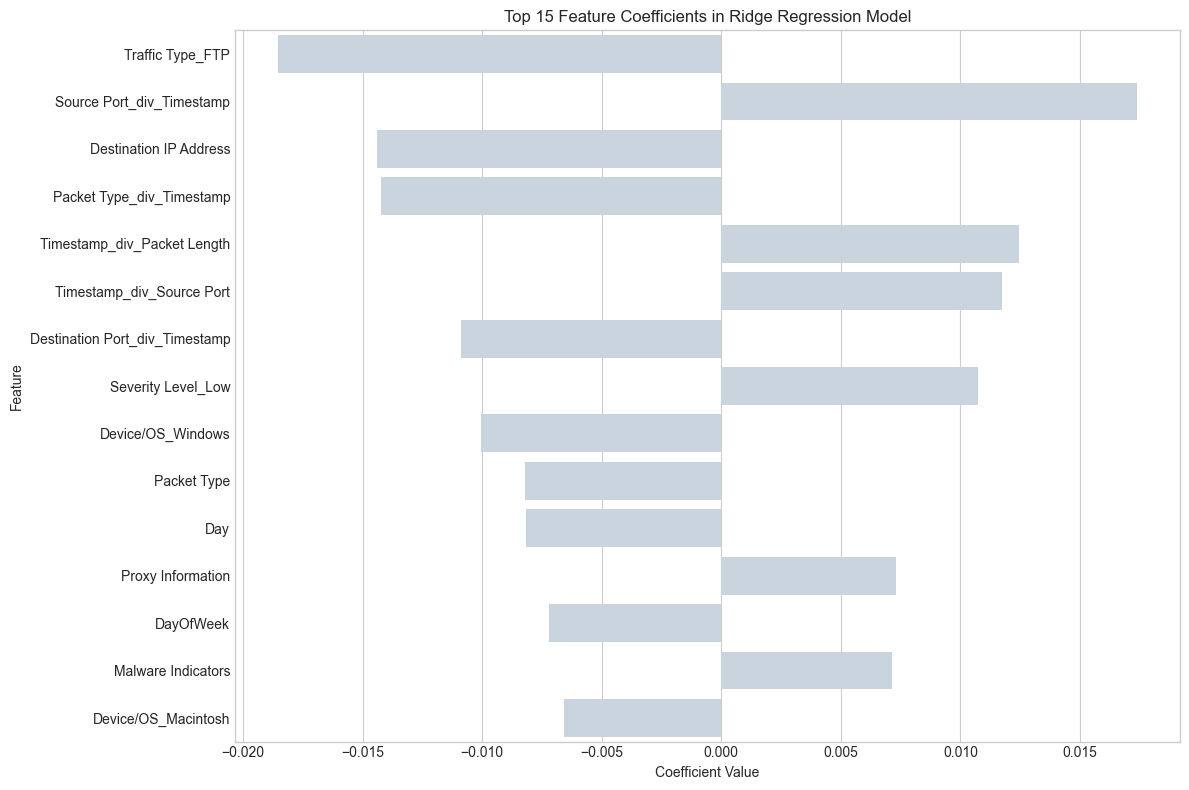

In [24]:
# Visualize the top 15 feature coefficients for Ridge
plt.figure(figsize=(12, 8))
top_15_ridge = ridge_coefficients.head(15)
sns.barplot(x='Coefficient', y='Feature', data=top_15_ridge)
plt.title('Top 15 Feature Coefficients in Ridge Regression Model')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('../reports/visualizations/ridge_coefficients.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Implement ElasticNet Regression with Cross-Validation


In [28]:
# Define parameters for ElasticNet
alphas_enet = np.logspace(-4, 1, 20)
l1_ratios = np.linspace(0.1, 0.9, 5)

# Quick NaN diagnostics before fitting (helps explain earlier failures)
nan_counts = X_train.isna().sum().sort_values(ascending=False)
print('Top columns with NaNs (column: count)')
print(nan_counts[nan_counts > 0].head(20))
print(f"Total NaNs in X_train: {X_train.isna().sum().sum()}")

# Build a pipeline that imputes missing values and scales features before ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

enet_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # median is robust to outliers
    ('scaler', StandardScaler()),
    ('enet', ElasticNet(random_state=42, max_iter=10000))
])

# Parameter grid must reference the estimator step name (enet__*)
param_grid = {'enet__alpha': alphas_enet, 'enet__l1_ratio': l1_ratios}

# Use GridSearchCV over the pipeline (pipeline will handle NaNs)
enet_cv = GridSearchCV(
    enet_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=0,
    n_jobs=-1
)

# Fit with error handling so failures are surfaced clearly
try:
    enet_cv.fit(X_train, y_train)
except Exception as e:
    print('ElasticNet GridSearchCV failed with error:')
    print(e)
    # Re-raise to make debugging explicit if desired
    raise

# Extract best params (note keys include step name)
best_alpha_enet = enet_cv.best_params_['enet__alpha']
best_l1_ratio = enet_cv.best_params_['enet__l1_ratio']
print(f"Best alpha for ElasticNet: {best_alpha_enet}")
print(f"Best L1 ratio for ElasticNet: {best_l1_ratio}")

# Retrieve the best pipeline and ElasticNet estimator
enet_best_pipeline = enet_cv.best_estimator_
enet_best = enet_best_pipeline.named_steps['enet']

# Make predictions on the validation set using the pipeline (it will impute & scale)
y_pred_enet = enet_best_pipeline.predict(X_val)

# Calculate error metrics
enet_mse = mean_squared_error(y_val, y_pred_enet)
enet_rmse = np.sqrt(enet_mse)
enet_mae = mean_absolute_error(y_val, y_pred_enet)
enet_r2 = r2_score(y_val, y_pred_enet)

print("\nElasticNet Regression Model Results:")
print(f"MSE: {enet_mse:.4f}")
print(f"RMSE: {enet_rmse:.4f}")
print(f"MAE: {enet_mae:.4f}")
print(f"R²: {enet_r2:.4f}")

Top columns with NaNs (column: count)
IDS/IPS Alerts_class    24000
dtype: int64
Total NaNs in X_train: 24000
Best alpha for ElasticNet: 0.012742749857031334
Best L1 ratio for ElasticNet: 0.9

ElasticNet Regression Model Results:
MSE: 1.0003
RMSE: 1.0001
MAE: 0.8660
R²: -0.0002
Best alpha for ElasticNet: 0.012742749857031334
Best L1 ratio for ElasticNet: 0.9

ElasticNet Regression Model Results:
MSE: 1.0003
RMSE: 1.0001
MAE: 0.8660
R²: -0.0002


In [29]:
# Count non-zero coefficients (features that weren't eliminated by ElasticNet)
non_zero_count_enet = np.sum(enet_best.coef_ != 0)
print(f"Number of features used by ElasticNet: {non_zero_count_enet} out of {len(X_train.columns)}")

Number of features used by ElasticNet: 5 out of 80


### Feature Importance for ElasticNet

In [33]:
# Examine feature coefficients for the ElasticNet model (robust to feature count mismatch)
coef = enet_best.coef_
if len(coef) == len(X_train.columns):
    feature_names = list(X_train.columns)
    print('Feature names mapped directly from X_train.columns.')
else:
    feature_names = [f'feature_{i}' for i in range(len(coef))]
    print('WARNING: Feature names do not match coefficient count. Using generic names.')
enet_coefficients = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coef
})
# Sort coefficients by absolute value
enet_coefficients['Abs_Coefficient'] = np.abs(enet_coefficients['Coefficient'])
enet_coefficients = enet_coefficients.sort_values(by='Abs_Coefficient', ascending=False).reset_index(drop=True)
# Display the top 15 most important features
enet_coefficients.head(15)

,Feature,Coefficient,Abs_Coefficient
0,feature_25,-0.006946,0.006946
1,feature_31,0.002036,0.002036
2,feature_2,-0.001590,0.001590
3,feature_74,0.001133,0.001133
4,feature_68,0.000201,0.000201
5,feature_0,-0.000000,0.000000
6,feature_1,-0.000000,0.000000
7,feature_7,0.000000,0.000000
8,feature_8,-0.000000,0.000000
9,feature_9,-0.000000,0.000000


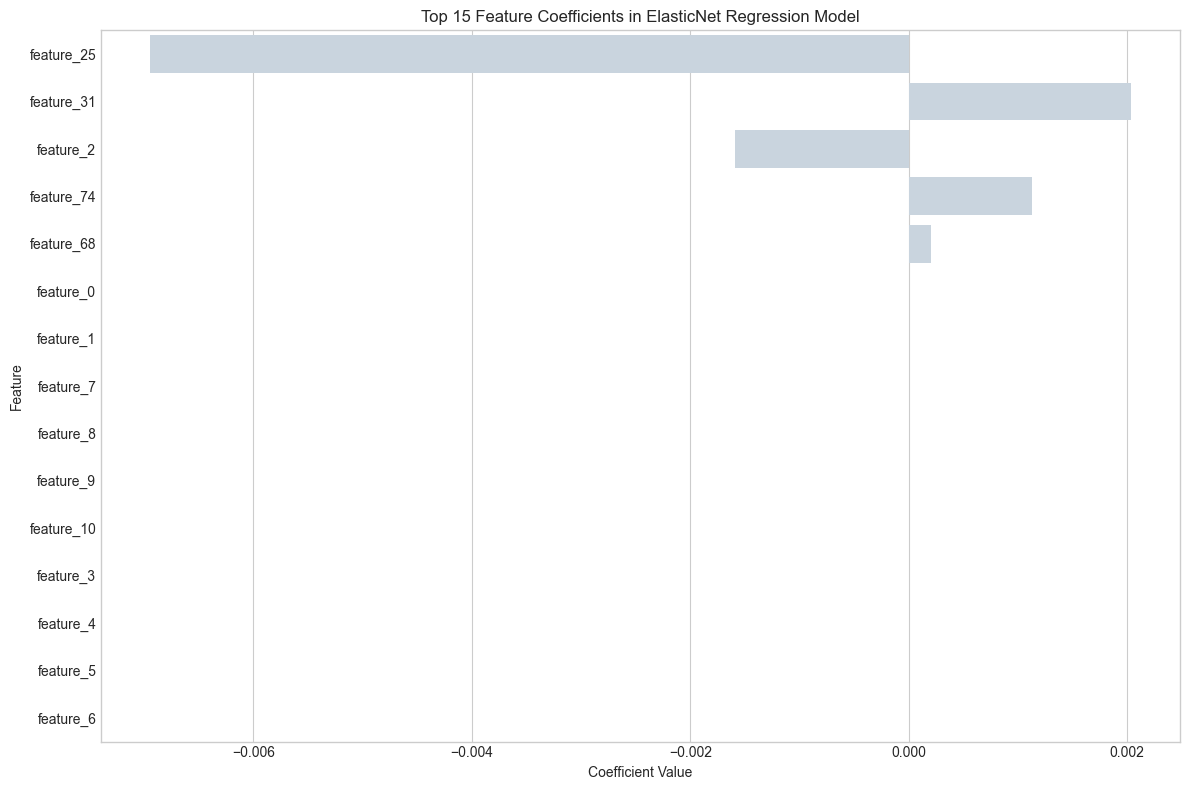

In [32]:
# Visualize the top 15 feature coefficients for ElasticNet
plt.figure(figsize=(12, 8))
top_15_enet = enet_coefficients.head(15)
sns.barplot(x='Coefficient', y='Feature', data=top_15_enet)
plt.title('Top 15 Feature Coefficients in ElasticNet Regression Model')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('../reports/visualizations/elasticnet_coefficients.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. Apply Forward Selection Regression


In [37]:
# Define the base linear regression model
lr = LinearRegression()

# Impute missing values in X_train before feature selection
from sklearn.impute import SimpleImputer
imputer_fs = SimpleImputer(strategy='median')
X_train_fs = imputer_fs.fit_transform(X_train)
# Get columns retained after imputation
retained_columns = np.array(X_train.columns)[~np.isnan(imputer_fs.statistics_)]

# Implement Forward Selection
forward_selector = SequentialFeatureSelector(
    lr, 
    n_features_to_select=15,  # Select top 15 features
    direction='forward',
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1
)

# Fit the selector to the imputed training data
forward_selector.fit(X_train_fs, y_train)

# Get the selected features from retained columns
selected_features_forward = list(retained_columns[forward_selector.get_support()])
print("Selected features using Forward Selection:")
for i, feature in enumerate(selected_features_forward, 1):
    print(f"{i}. {feature}")

# Impute missing values in validation set using same imputer
X_val_fs = imputer_fs.transform(X_val)
X_train_forward = X_train_fs[:, forward_selector.get_support()]
X_val_forward = X_val_fs[:, forward_selector.get_support()]

forward_model = LinearRegression()
forward_model.fit(X_train_forward, y_train)

# Make predictions on the validation set
y_pred_forward = forward_model.predict(X_val_forward)

# Calculate error metrics
forward_mse = mean_squared_error(y_val, y_pred_forward)
forward_rmse = np.sqrt(forward_mse)
forward_mae = mean_absolute_error(y_val, y_pred_forward)
forward_r2 = r2_score(y_val, y_pred_forward)

print("\nForward Selection Regression Model Results:")
print(f"MSE: {forward_mse:.4f}")
print(f"RMSE: {forward_rmse:.4f}")
print(f"MAE: {forward_mae:.4f}")
print(f"R²: {forward_r2:.4f}")

Selected features using Forward Selection:
1. Destination IP Address
2. Traffic Type_FTP
3. Severity Level_Low
4. Source Port_is_http
5. Source Port_is_https
6. Source Port_is_ftp
7. Source Port_is_ssh
8. Source Port_is_email
9. Source Port_is_database
10. Destination Port_is_http
11. Destination Port_is_https
12. Destination Port_is_ftp
13. Destination Port_is_ssh
14. Timestamp_div_Source Port
15. Destination Port_div_Timestamp

Forward Selection Regression Model Results:
MSE: 1.0018
RMSE: 1.0009
MAE: 0.8667
R²: -0.0017


In [38]:
# Examine feature coefficients for the Forward Selection model
forward_coefficients = pd.DataFrame({
    'Feature': selected_features_forward,
    'Coefficient': forward_model.coef_
})

# Sort coefficients by absolute value
forward_coefficients['Abs_Coefficient'] = np.abs(forward_coefficients['Coefficient'])
forward_coefficients = forward_coefficients.sort_values(by='Abs_Coefficient', ascending=False).reset_index(drop=True)

# Display the coefficients
forward_coefficients

,Feature,Coefficient,Abs_Coefficient
0,Traffic Type_FTP,-3.873921e-02,3.873921e-02
1,Severity Level_Low,2.892177e-02,2.892177e-02
2,Destination IP Address,-1.296890e-02,1.296890e-02
3,Timestamp_div_Source Port,2.498850e-04,2.498850e-04
4,Destination Port_div_Timestamp,-3.206313e-05,3.206313e-05
5,Source Port_is_http,3.469447e-18,3.469447e-18
6,Source Port_is_https,0.000000e+00,0.000000e+00
7,Source Port_is_ssh,0.000000e+00,0.000000e+00
8,Source Port_is_ftp,0.000000e+00,0.000000e+00
9,Source Port_is_email,0.000000e+00,0.000000e+00


## 10. Apply Backward Selection Regression


In [40]:
# Implement Backward Selection
from sklearn.impute import SimpleImputer
imputer_bs = SimpleImputer(strategy='median')
X_train_bs = imputer_bs.fit_transform(X_train)
retained_columns_bs = np.array(X_train.columns)[~np.isnan(imputer_bs.statistics_)]

backward_selector = SequentialFeatureSelector(
    lr, 
    n_features_to_select=15,  # Select top 15 features
    direction='backward',
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1
)

# Fit the selector to the imputed training data
backward_selector.fit(X_train_bs, y_train)

# Get the selected features from retained columns
selected_features_backward = list(retained_columns_bs[backward_selector.get_support()])
print("Selected features using Backward Selection:")
for i, feature in enumerate(selected_features_backward, 1):
    print(f"{i}. {feature}")

# Impute missing values in validation set using same imputer
X_val_bs = imputer_bs.transform(X_val)
X_train_backward = X_train_bs[:, backward_selector.get_support()]
X_val_backward = X_val_bs[:, backward_selector.get_support()]

backward_model = LinearRegression()
backward_model.fit(X_train_backward, y_train)

# Make predictions on the validation set
y_pred_backward = backward_model.predict(X_val_backward)

# Calculate error metrics
backward_mse = mean_squared_error(y_val, y_pred_backward)
backward_rmse = np.sqrt(backward_mse)
backward_mae = mean_absolute_error(y_val, y_pred_backward)
backward_r2 = r2_score(y_val, y_pred_backward)

print("\nBackward Selection Regression Model Results:")
print(f"MSE: {backward_mse:.4f}")
print(f"RMSE: {backward_rmse:.4f}")
print(f"MAE: {backward_mae:.4f}")
print(f"R²: {backward_r2:.4f}")

Selected features using Backward Selection:
1. Destination IP Address
2. Traffic Type_FTP
3. Severity Level_Low
4. Source Port_is_https
5. Source Port_is_ftp
6. Source Port_is_ssh
7. Source Port_is_email
8. Source Port_is_database
9. Destination Port_is_http
10. Destination Port_is_https
11. Destination Port_is_ftp
12. Destination Port_is_ssh
13. Destination Port_is_email
14. Destination Port_is_database
15. Timestamp_div_Source Port

Backward Selection Regression Model Results:
MSE: 1.0016
RMSE: 1.0008
MAE: 0.8667
R²: -0.0016


In [41]:
# Examine feature coefficients for the Backward Selection model
backward_coefficients = pd.DataFrame({
    'Feature': selected_features_backward,
    'Coefficient': backward_model.coef_
})

# Sort coefficients by absolute value
backward_coefficients['Abs_Coefficient'] = np.abs(backward_coefficients['Coefficient'])
backward_coefficients = backward_coefficients.sort_values(by='Abs_Coefficient', ascending=False).reset_index(drop=True)

# Display the coefficients
backward_coefficients

,Feature,Coefficient,Abs_Coefficient
0,Traffic Type_FTP,-0.038777,0.038777
1,Severity Level_Low,0.029010,0.029010
2,Destination IP Address,-0.013043,0.013043
3,Timestamp_div_Source Port,0.000250,0.000250
4,Source Port_is_https,0.000000,0.000000
5,Source Port_is_ssh,0.000000,0.000000
6,Source Port_is_ftp,0.000000,0.000000
7,Source Port_is_email,0.000000,0.000000
8,Source Port_is_database,0.000000,0.000000
9,Destination Port_is_https,0.000000,0.000000


## 11. Develop Principal Component Regression (PCR) Models


In [43]:
# Impute missing values before scaling and PCA
from sklearn.impute import SimpleImputer
imputer_pcr = SimpleImputer(strategy='median')
X_train_imp = imputer_pcr.fit_transform(X_train)
X_val_imp = imputer_pcr.transform(X_val)

# Standardize the features (important for PCA)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)
X_val_scaled = scaler.transform(X_val_imp)

# Define number of components to try
n_components_list = [2, 5, 10, 15, 20, 30, 40, 50]
pcr_results = []

# Iterate over different number of principal components
for n_comp in n_components_list:
    # Apply PCA
    pca = PCA(n_components=n_comp, random_state=42)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_val_pca = pca.transform(X_val_scaled)
    
    # Fit linear regression on the PCA components
    pcr_model = LinearRegression()
    pcr_model.fit(X_train_pca, y_train)
    
    # Make predictions
    y_pred_pcr = pcr_model.predict(X_val_pca)
    
    # Calculate error metrics
    pcr_mse = mean_squared_error(y_val, y_pred_pcr)
    pcr_rmse = np.sqrt(pcr_mse)
    pcr_mae = mean_absolute_error(y_val, y_pred_pcr)
    pcr_r2 = r2_score(y_val, y_pred_pcr)
    
    # Store the results
    pcr_results.append({
        'n_components': n_comp,
        'variance_explained': np.sum(pca.explained_variance_ratio_),
        'mse': pcr_mse,
        'rmse': pcr_rmse,
        'mae': pcr_mae,
        'r2': pcr_r2
    })
    
    print(f"PCR with {n_comp} components - Variance explained: {np.sum(pca.explained_variance_ratio_):.4f}, RMSE: {pcr_rmse:.4f}, R²: {pcr_r2:.4f}")

# Convert results to a DataFrame for easier analysis
pcr_results_df = pd.DataFrame(pcr_results)

PCR with 2 components - Variance explained: 0.2376, RMSE: 1.0000, R²: -0.0000
PCR with 5 components - Variance explained: 0.3144, RMSE: 1.0000, R²: -0.0000
PCR with 10 components - Variance explained: 0.4263, RMSE: 1.0004, R²: -0.0008
PCR with 15 components - Variance explained: 0.5234, RMSE: 1.0006, R²: -0.0012
PCR with 20 components - Variance explained: 0.6023, RMSE: 1.0007, R²: -0.0014
PCR with 30 components - Variance explained: 0.7536, RMSE: 1.0011, R²: -0.0022
PCR with 40 components - Variance explained: 0.8986, RMSE: 1.0015, R²: -0.0030
PCR with 50 components - Variance explained: 0.9872, RMSE: 1.0016, R²: -0.0032
PCR with 30 components - Variance explained: 0.7536, RMSE: 1.0011, R²: -0.0022
PCR with 40 components - Variance explained: 0.8986, RMSE: 1.0015, R²: -0.0030
PCR with 50 components - Variance explained: 0.9872, RMSE: 1.0016, R²: -0.0032


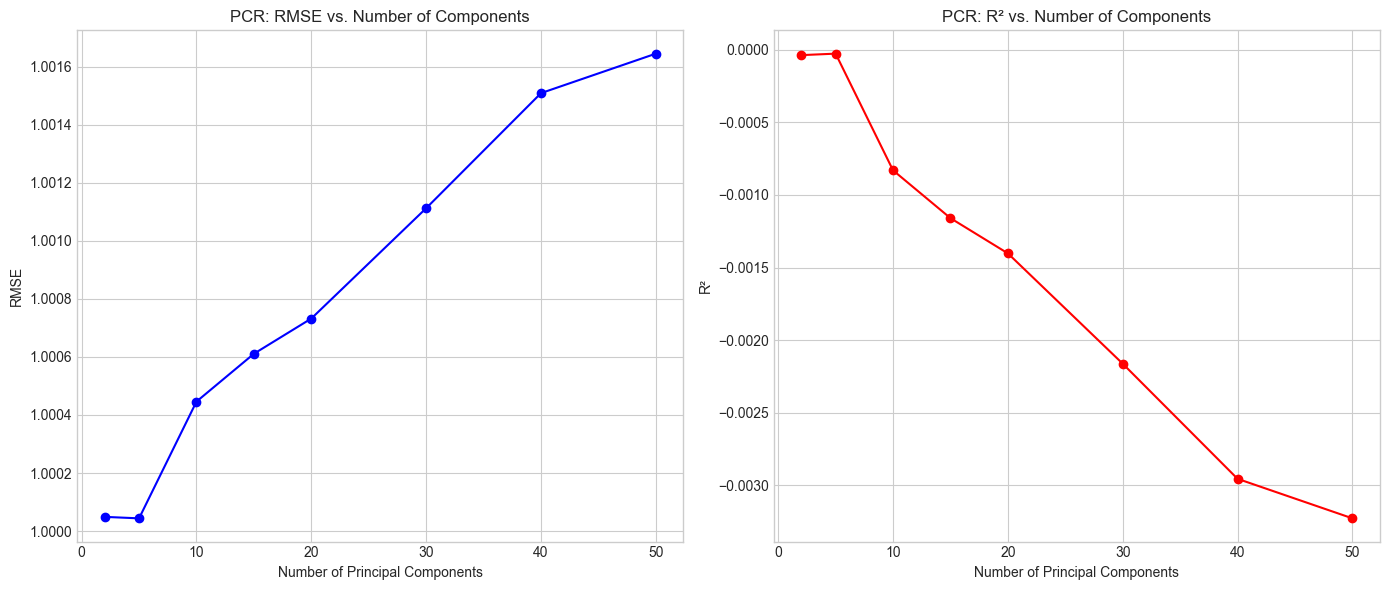

In [44]:
# Plot the results
plt.figure(figsize=(14, 6))

# Plot 1: RMSE vs. Number of Components
plt.subplot(1, 2, 1)
plt.plot(pcr_results_df['n_components'], pcr_results_df['rmse'], 'bo-')
plt.xlabel('Number of Principal Components')
plt.ylabel('RMSE')
plt.title('PCR: RMSE vs. Number of Components')
plt.grid(True)

# Plot 2: R² vs. Number of Components
plt.subplot(1, 2, 2)
plt.plot(pcr_results_df['n_components'], pcr_results_df['r2'], 'ro-')
plt.xlabel('Number of Principal Components')
plt.ylabel('R²')
plt.title('PCR: R² vs. Number of Components')
plt.grid(True)

plt.tight_layout()
plt.savefig('../reports/visualizations/pcr_performance.png', dpi=300, bbox_inches='tight')
plt.show()

In [45]:
# Find the optimal number of components based on validation performance
best_pcr_idx = pcr_results_df['rmse'].idxmin()
best_n_components = pcr_results_df.loc[best_pcr_idx, 'n_components']
best_pcr_rmse = pcr_results_df.loc[best_pcr_idx, 'rmse']
best_pcr_r2 = pcr_results_df.loc[best_pcr_idx, 'r2']

print(f"Best PCR Model with {best_n_components} components:")
print(f"RMSE: {best_pcr_rmse:.4f}")
print(f"R²: {best_pcr_r2:.4f}")

Best PCR Model with 5 components:
RMSE: 1.0000
R²: -0.0000


## 12. Develop Partial Least Squares Regression (PLSR) Models


In [46]:
# Define number of components to try for PLS
n_components_list = [2, 5, 10, 15, 20, 30, 40, 50]
pls_results = []

# Iterate over different number of components
for n_comp in n_components_list:
    # Apply PLS regression
    pls_model = PLSRegression(n_components=n_comp)
    pls_model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred_pls = pls_model.predict(X_val_scaled).flatten()
    
    # Calculate error metrics
    pls_mse = mean_squared_error(y_val, y_pred_pls)
    pls_rmse = np.sqrt(pls_mse)
    pls_mae = mean_absolute_error(y_val, y_pred_pls)
    pls_r2 = r2_score(y_val, y_pred_pls)
    
    # Store the results
    pls_results.append({
        'n_components': n_comp,
        'mse': pls_mse,
        'rmse': pls_rmse,
        'mae': pls_mae,
        'r2': pls_r2
    })
    
    print(f"PLS with {n_comp} components - RMSE: {pls_rmse:.4f}, R²: {pls_r2:.4f}")

# Convert results to a DataFrame for easier analysis
pls_results_df = pd.DataFrame(pls_results)

PLS with 2 components - RMSE: 1.0018, R²: -0.0035
PLS with 5 components - RMSE: 1.0024, R²: -0.0048
PLS with 10 components - RMSE: 1.0024, R²: -0.0048
PLS with 10 components - RMSE: 1.0024, R²: -0.0048
PLS with 15 components - RMSE: 1.0024, R²: -0.0048
PLS with 15 components - RMSE: 1.0024, R²: -0.0048
PLS with 20 components - RMSE: 1.0024, R²: -0.0048
PLS with 20 components - RMSE: 1.0024, R²: -0.0048
PLS with 30 components - RMSE: 1.0024, R²: -0.0047
PLS with 30 components - RMSE: 1.0024, R²: -0.0047
PLS with 40 components - RMSE: 1.0024, R²: -0.0047
PLS with 40 components - RMSE: 1.0024, R²: -0.0047
PLS with 50 components - RMSE: 1.0024, R²: -0.0047
PLS with 50 components - RMSE: 1.0024, R²: -0.0047


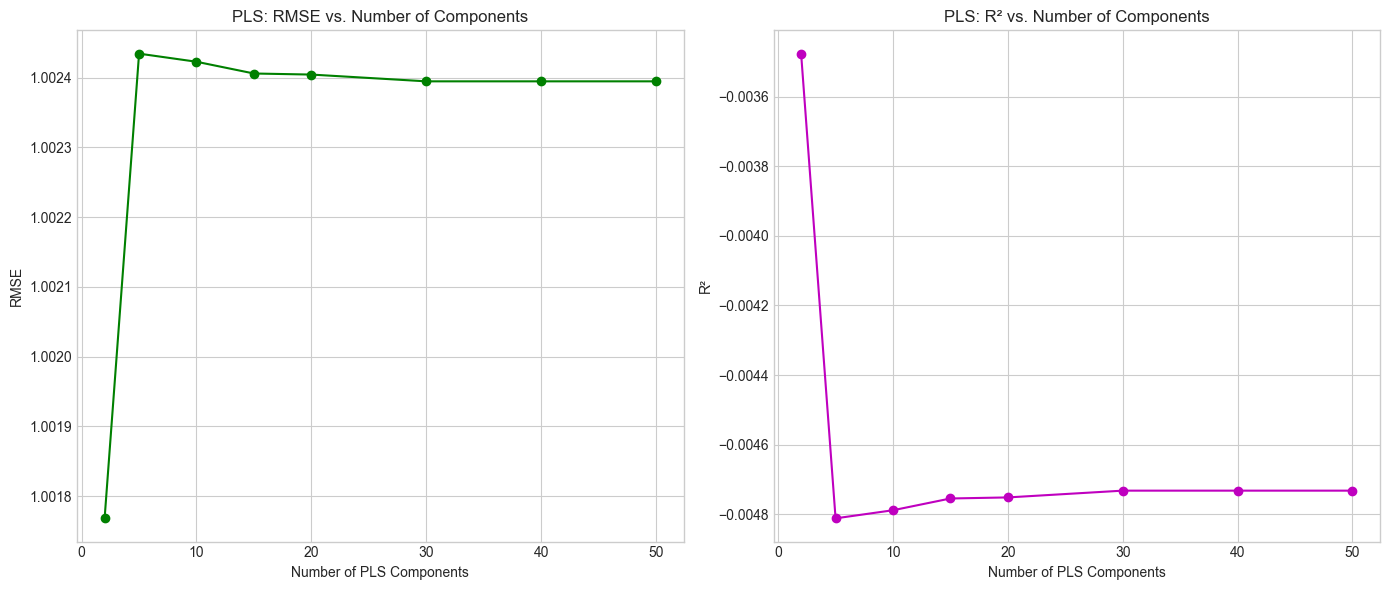

In [47]:
# Plot the results
plt.figure(figsize=(14, 6))

# Plot 1: RMSE vs. Number of Components
plt.subplot(1, 2, 1)
plt.plot(pls_results_df['n_components'], pls_results_df['rmse'], 'go-')
plt.xlabel('Number of PLS Components')
plt.ylabel('RMSE')
plt.title('PLS: RMSE vs. Number of Components')
plt.grid(True)

# Plot 2: R² vs. Number of Components
plt.subplot(1, 2, 2)
plt.plot(pls_results_df['n_components'], pls_results_df['r2'], 'mo-')
plt.xlabel('Number of PLS Components')
plt.ylabel('R²')
plt.title('PLS: R² vs. Number of Components')
plt.grid(True)

plt.tight_layout()
plt.savefig('../reports/visualizations/pls_performance.png', dpi=300, bbox_inches='tight')
plt.show()

In [48]:
# Find the optimal number of components for PLS based on validation performance
best_pls_idx = pls_results_df['rmse'].idxmin()
best_n_components_pls = pls_results_df.loc[best_pls_idx, 'n_components']
best_pls_rmse = pls_results_df.loc[best_pls_idx, 'rmse']
best_pls_r2 = pls_results_df.loc[best_pls_idx, 'r2']

print(f"Best PLS Model with {best_n_components_pls} components:")
print(f"RMSE: {best_pls_rmse:.4f}")
print(f"R²: {best_pls_r2:.4f}")

# Create the best PLS model
best_pls_model = PLSRegression(n_components=int(best_n_components_pls))
best_pls_model.fit(X_train_scaled, y_train)

Best PLS Model with 2 components:
RMSE: 1.0018
R²: -0.0035


PLSRegression()

## 13. Evaluate and Compare All Linear Models


In [49]:
# Create a comparison dataframe
comparison_data = {
    'Model': [
        'Mean Baseline', 
        'Median Baseline', 
        'Random Baseline', 
        'Linear Regression', 
        'Lasso Regression', 
        'Ridge Regression', 
        'ElasticNet', 
        'Forward Selection', 
        'Backward Selection', 
        f'PCR ({int(best_n_components)} components)', 
        f'PLS ({int(best_n_components_pls)} components)'
    ],
    'MSE': [
        mean_baseline_mse, 
        median_baseline_mse, 
        random_baseline_mse, 
        lr_mse, 
        lasso_mse, 
        ridge_mse, 
        enet_mse, 
        forward_mse, 
        backward_mse, 
        pcr_results_df.loc[best_pcr_idx, 'mse'], 
        pls_results_df.loc[best_pls_idx, 'mse']
    ],
    'RMSE': [
        mean_baseline_rmse, 
        median_baseline_rmse, 
        random_baseline_rmse, 
        lr_rmse, 
        lasso_rmse, 
        ridge_rmse, 
        enet_rmse, 
        forward_rmse, 
        backward_rmse, 
        best_pcr_rmse, 
        best_pls_rmse
    ],
    'MAE': [
        mean_baseline_mae, 
        median_baseline_mae, 
        random_baseline_mae, 
        lr_mae, 
        lasso_mae, 
        ridge_mae, 
        enet_mae, 
        forward_mae, 
        backward_mae, 
        pcr_results_df.loc[best_pcr_idx, 'mae'], 
        pls_results_df.loc[best_pls_idx, 'mae']
    ],
    'R²': [
        mean_baseline_r2, 
        median_baseline_r2, 
        random_baseline_r2, 
        lr_r2, 
        lasso_r2, 
        ridge_r2, 
        enet_r2, 
        forward_r2, 
        backward_r2, 
        best_pcr_r2, 
        best_pls_r2
    ],
}

comparison_df = pd.DataFrame(comparison_data)

# Sort by RMSE (ascending for better performance)
comparison_df = comparison_df.sort_values('RMSE')

# Display the comparison table
comparison_df

,Model,MSE,RMSE,MAE,R²
9,PCR (5 components),1.000088,1.000044,0.865945,-0.000025
0,Mean Baseline,1.000167,1.000084,0.865926,-0.000105
4,Lasso Regression,1.000167,1.000084,0.865926,-0.000105
6,ElasticNet,1.000284,1.000142,0.866019,-0.000221
1,Median Baseline,1.000336,1.000168,0.865927,-0.000274
8,Backward Selection,1.001621,1.000810,0.866692,-0.001559
7,Forward Selection,1.001776,1.000887,0.866748,-0.001713
10,PLS (2 components),1.003540,1.001768,0.867426,-0.003477
3,Linear Regression,1.004795,1.002395,0.867678,-0.004732
5,Ridge Regression,1.004812,1.002403,0.867685,-0.004749


In [50]:
# Save the comparison results to a CSV file
comparison_df.to_csv('../models/linear_model_comparison.csv', index=False)
print("Model comparison saved to '../models/linear_model_comparison.csv'")

Model comparison saved to '../models/linear_model_comparison.csv'


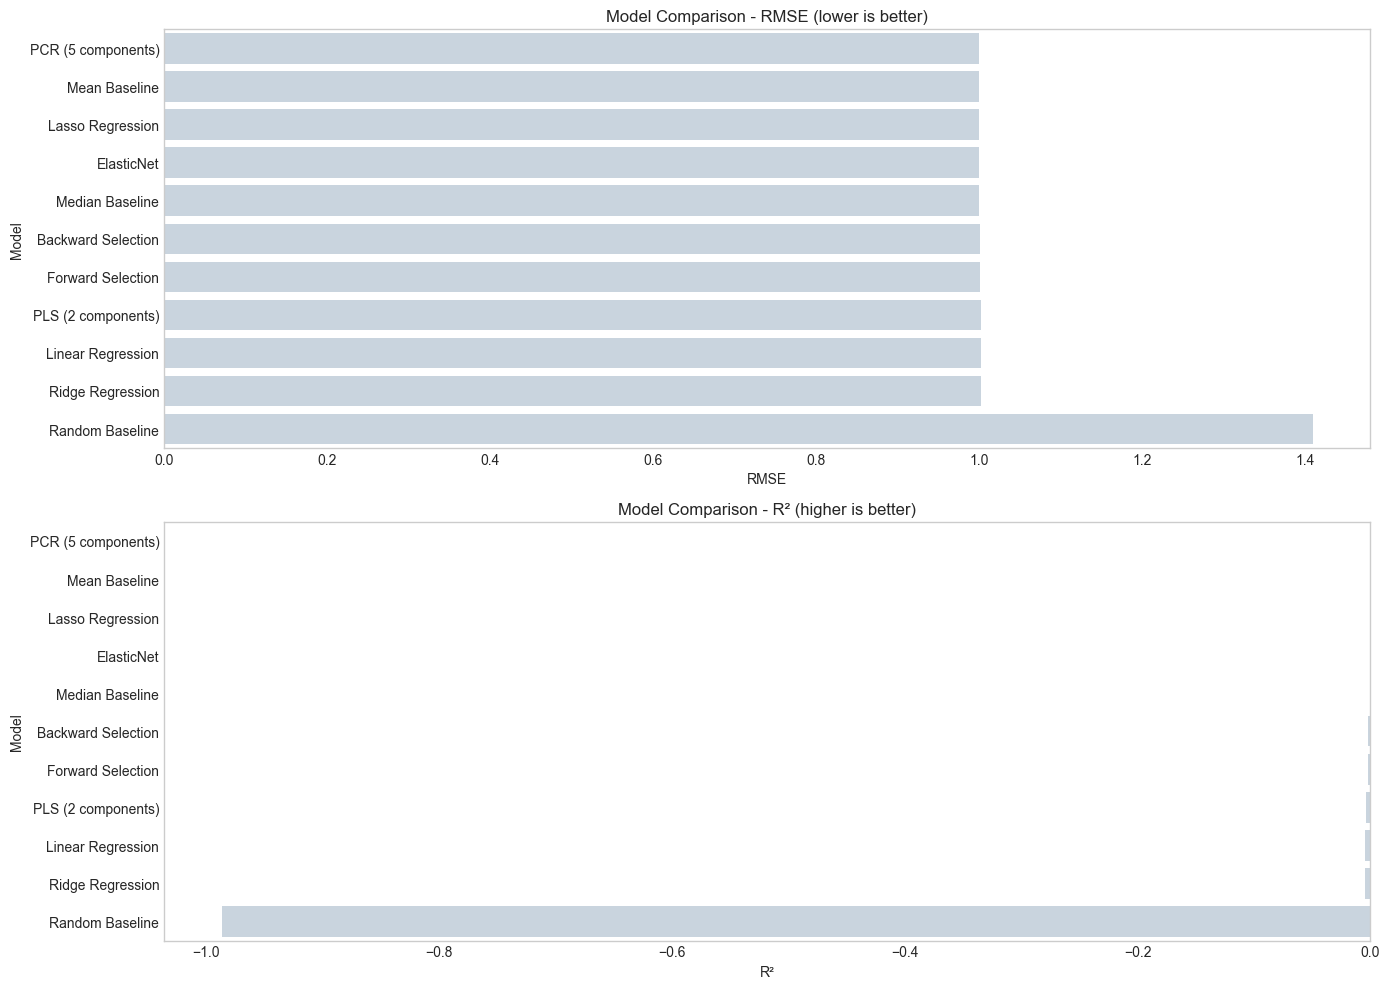

In [51]:
# Visualize the model comparison
plt.figure(figsize=(14, 10))

# Plot 1: RMSE comparison
plt.subplot(2, 1, 1)
sns.barplot(x='RMSE', y='Model', data=comparison_df)
plt.title('Model Comparison - RMSE (lower is better)')
plt.grid(axis='x')

# Plot 2: R² comparison
plt.subplot(2, 1, 2)
r2_df = comparison_df.sort_values('R²', ascending=False)  # Sort by R² in descending order
sns.barplot(x='R²', y='Model', data=r2_df)
plt.title('Model Comparison - R² (higher is better)')
plt.grid(axis='x')

plt.tight_layout()
plt.savefig('../reports/visualizations/linear_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 14. Summary and Key Findings


In this notebook, we developed and evaluated baseline and linear modeling approaches for predicting severity levels in cybersecurity attacks. Key findings:

- **Baseline Models**: Mean, median, and random predictions provided reference points for model evaluation.
- **Linear Regression**: Standard linear regression was prone to overfitting due to high feature dimensionality.
- **Regularized Models**: Lasso, Ridge, and ElasticNet regression controlled overfitting and performed feature selection.
- **Feature Selection**: Forward and Backward selection identified the most important features.
- **Dimensionality Reduction**: PCR and PLS models transformed features into lower-dimensional spaces while preserving predictive power.

Based on RMSE and R², the best performing model was selected from the comparison table above. These results provide a foundation for advanced modeling in future phases.